In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import common.data as data
import common.nn as nn

plt.style.use("ggplot")


In [29]:
paths = data.get_dataset_paths("../data")
dataset = data.Marconi100Dataset(paths, data.Scaling.STANDARD)

Loading: 100%|██████████| 249/249 [01:14<00:00,  3.35it/s]


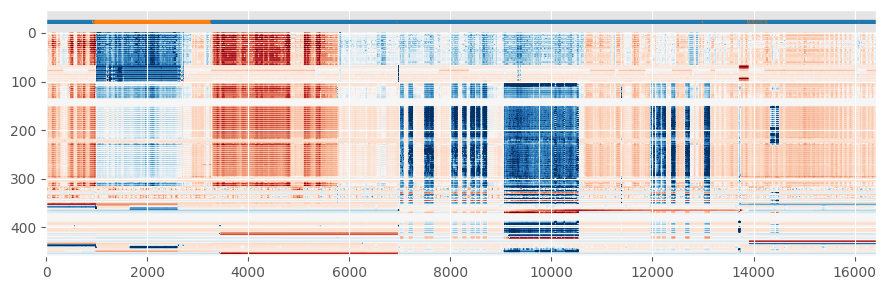

In [30]:
hpcsv, labels = dataset[1]

nn.plot_dataframe(hpcsv, pd.Series(labels.values))
plt.show()

Num samples: 241
Num time steps: 3270454

min: 1980
max: 20511
mean: 13570.3
median: 13393.0

  < 1024:      0 (0.0%)
 >= 1024:    241 (100.0%)


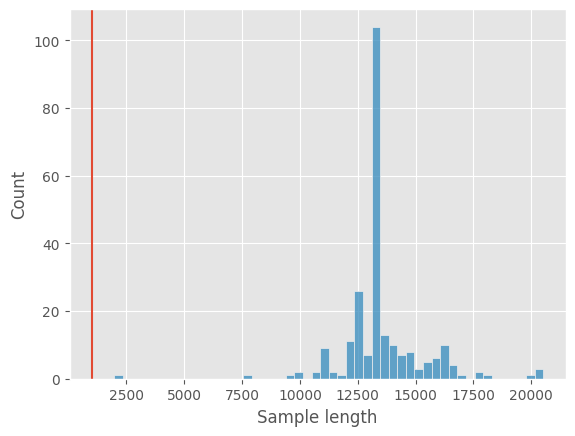

In [31]:
lengths = []
for i in range(len(dataset)):
    df, labels = dataset[i]
    lengths.append(len(labels))

num_time_steps = sum(lengths)
min_len = min(lengths)
max_len = max(lengths)
mean_len = np.mean(lengths)
median_len = np.median(lengths)

counter_len = Counter(lengths)
num_samples = len(dataset)

print(f"Num samples: {num_samples}")
print(f"Num time steps: {num_time_steps}")
print()
print(f"min: {min_len}")
print(f"max: {max_len}")
print(f"mean: {mean_len:.1f}")
print(f"median: {median_len}")
ax = sns.histplot(lengths, bins=50) # type: ignore
ax.set_xlabel("Sample length")

lim = 1024
lt = sum(counter_len[i] for i in range(lim))
lt_p = lt / num_samples * 100
gt = num_samples - lt
gt_p = 100 - lt_p

ax.axvline(lim)
print()
print(f"  < {lim}: {lt:6d} ({lt_p:.1f}%)")
print(f" >= {lim}: {gt:6d} ({gt_p:.1f}%)")
        
plt.show()

Num anomalies: 26037
Num anomalous time steps: 124755
Anomaly ratio: 3.81%

min: 1
max: 5293
mean: 4.8
median: 1.0

  < 4:  24037 (92.3%)
 >= 4:   2000 (7.7%)
>= 10:    435 (1.7%)


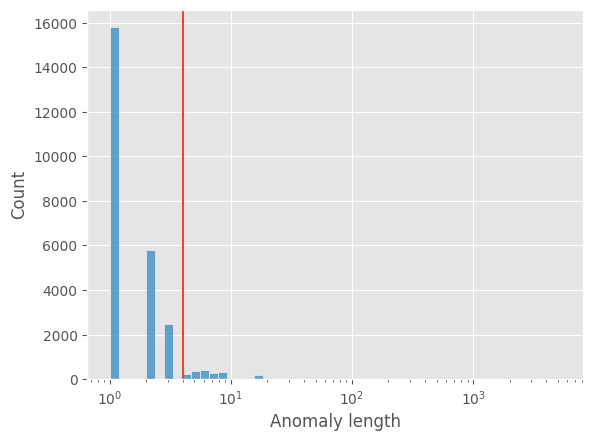

In [32]:
sequences = []
for i in range(len(dataset)):
    df, labels = dataset[i]

    count = 0
    counting = False
    for l in labels:
        if l == 0:
            if counting:
                sequences.append(count)
                count = 0
                counting = False
        else:
            counting = True
            count += 1

num_anomal_ts = sum(sequences)
min_seq = min(sequences)
max_seq = max(sequences)
mean_seq = np.mean(sequences)
median_seq = np.median(sequences)

counter_seq = Counter(sequences)
num_anomalies = len(sequences)

lim = 4
lt = sum(counter_seq[i] for i in range(lim))
lt_p = lt / num_anomalies
gt = num_anomalies - lt
gt_p = 1 - lt_p
gg = sum(counter_seq[i] for i in range(10, max_seq+1))
gg_p = gg / num_anomalies
anomaly_ratio = num_anomal_ts / num_time_steps

ax = sns.histplot(sequences, bins=50, log_scale=True) # type: ignore
ax.set_xlabel("Anomaly length")
ax.axvline(lim)

print(f"Num anomalies: {num_anomalies}")
print(f"Num anomalous time steps: {num_anomal_ts}")
print(f"Anomaly ratio: {anomaly_ratio:.2%}")
print()
print(f"min: {min_seq}")
print(f"max: {max_seq}")
print(f"mean: {mean_seq:.1f}")
print(f"median: {median_seq}")
print()
print(f"  < {lim}: {lt:6d} ({lt_p:.1%})")
print(f" >= {lim}: {gt:6d} ({gt_p:.1%})")
print(f">= 10: {gg:6d} ({gg_p:.1%})")

plt.show()
